# Sentiment Analysis of U.S. Airlines from X/Twitter

### Define the Business Context and Problem:
- The project analyzes Twitter data to derive consumer sentiments toward U.S. airlines.
- It identifies key positive and negative themes using sentiment analysis and topic modeling.

### Collect Data:

The provided Twitter dataset serves as secondary data.

### Data Hygiene and EDA:
- Cleaning the text (removing URLs, mentions, hashtags, and special characters).
- Visualizing sentiment distribution and generating word clouds for each sentiment.

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re
from sklearn.manifold import MDS

import warnings
warnings.filterwarnings('ignore')

/Users/bianca/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


1. Import essential libraries for data processing (pandas), visualization (matplotlib, WordCloud), and machine learning (scikit-learn).
2. Use nltk for text preprocessing and cleaning.

In [2]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bianca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Load the dataset (assuming the file name is 'Tweets.csv')
data = pd.read_csv('Tweets.csv')

# Inspect the dataset
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# Preprocess the data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#', '', text)       # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()                # Convert to lowercase
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

data['cleaned_text'] = data['text'].apply(clean_text)

In [6]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),said
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus youve added commercials experience tacky
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),didnt today must mean need take another trip
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing


* Remove URLs: Tweets often contain links that are irrelevant to sentiment analysis.
* Remove Mentions: Mentions of Twitter handles (@username) do not contribute to sentiment meaning.
* Remove Hashtags and Special Characters: Hashtags can clutter the text and are often redundant.
* Convert to Lowercase: Ensures consistent handling of text during processing.
* Remove Stopwords: Common words (e.g., "the," "and") do not carry sentiment value.



In [7]:
# Unique US Airlines
airlines = data['airline'].unique()
print(airlines)

['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


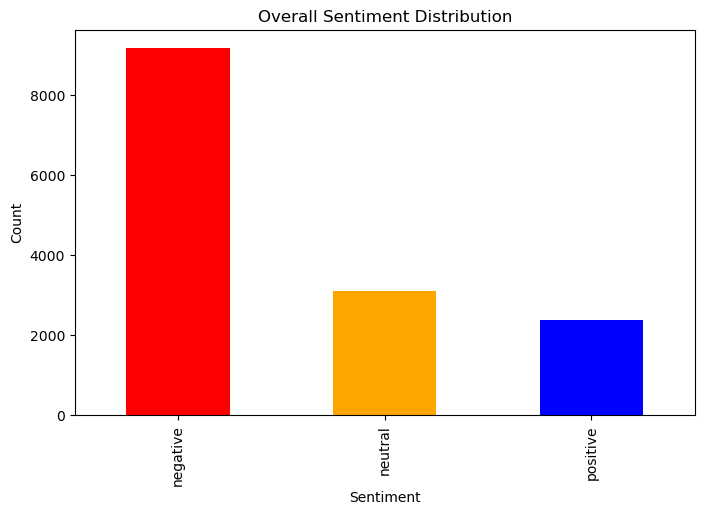

In [8]:
# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
data['airline_sentiment'].value_counts().plot(kind='bar', color=['red', 'orange', 'blue'])
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

This chart represents the distribution of sentiments (negative, neutral, and positive) in the dataset:

1. **Y-Axis (Count)**: Indicates the number of tweets for each sentiment category.
2. **X-Axis (Sentiment)**: Represents the three sentiment categories—negative, neutral, and positive.

### Observations:
- **Negative Sentiment**: The majority of tweets are classified as negative, showing the most prominent sentiment in the dataset. This suggests dissatisfaction among customers or frequent complaints.
- **Neutral Sentiment**: A smaller proportion of tweets fall under the neutral category, reflecting tweets that are neither explicitly positive nor negative.
- **Positive Sentiment**: The smallest number of tweets are classified as positive, indicating limited customer satisfaction or fewer commendations.

### Implications:
- Airlines need to address the underlying reasons for negative sentiments, such as delays, poor customer service, or other operational issues.
- Opportunities exist to convert neutral sentiments into positive experiences through improved customer engagement and targeted campaigns.

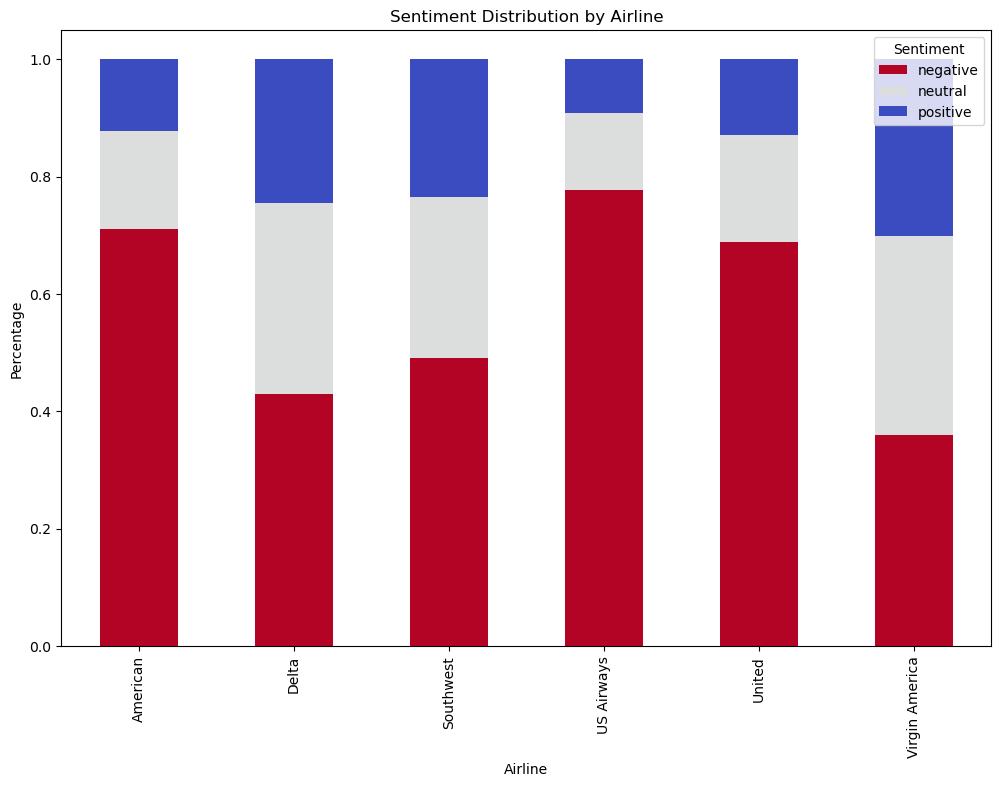

In [9]:
# Sentiment distribution by airline
airline_sentiment_counts = data.groupby(['airline', 'airline_sentiment']).size().unstack()
airline_sentiment_percentages = airline_sentiment_counts.div(airline_sentiment_counts.sum(axis=1), axis=0)

# Visualize sentiment percentages for each airline
reversed_cmap = plt.cm.get_cmap("coolwarm").reversed()
airline_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(12, 8), colormap=reversed_cmap)
plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Percentage')
plt.legend(title='Sentiment')
plt.show()

### **Key Observations**:
1. **Negative Sentiment** (Blue):
   - Negative sentiment is the most dominant across all airlines, as indicated by the largest blue sections.
   - Airlines like **United** and **American** seem to have the highest proportion of negative tweets compared to others.

2. **Neutral Sentiment** (Gray):
   - Neutral sentiment makes up a smaller proportion across most airlines.
   - Airlines like **Southwest** and **Delta** have a relatively higher percentage of neutral tweets, indicating informational or transactional interactions without strong emotional tones.

3. **Positive Sentiment** (Red):
   - Positive sentiment is the smallest category for all airlines, but **Virgin America** has the highest proportion of positive tweets compared to others.
   - Airlines like **American** and **United** have very small proportions of positive sentiment.

### **Implications**:
1. **American and United Airlines**:
   - These airlines show high negative sentiment and low positive sentiment.
   - **Focus Areas**:
     - Address frequent complaints (e.g., delays, customer service issues).
     - Implement marketing strategies to boost customer satisfaction and turn neutral experiences into positive ones.

2. **Southwest and Delta Airlines**:
   - These airlines have a healthier balance between negative and neutral sentiment, though negative still dominates.
   - **Focus Areas**:
     - Leverage neutral interactions to improve overall sentiment.
     - Highlight positive customer experiences in marketing campaigns.

3. **Virgin America**:
   - This airline has the best sentiment distribution, with a higher proportion of positive tweets compared to others.
   - **Focus Areas**:
     - Capitalize on its strong positive sentiment in advertising.
     - Ensure operational reliability to maintain its favorable reputation.

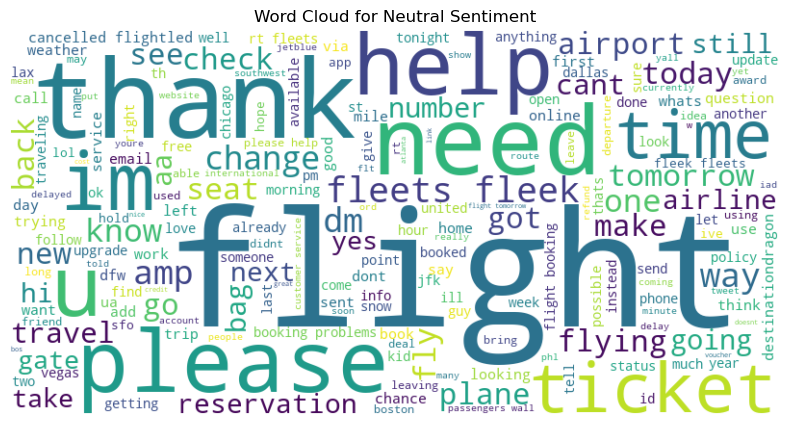

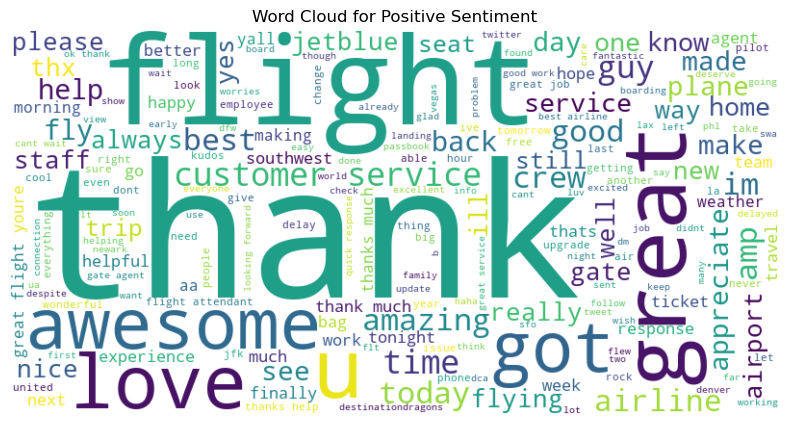

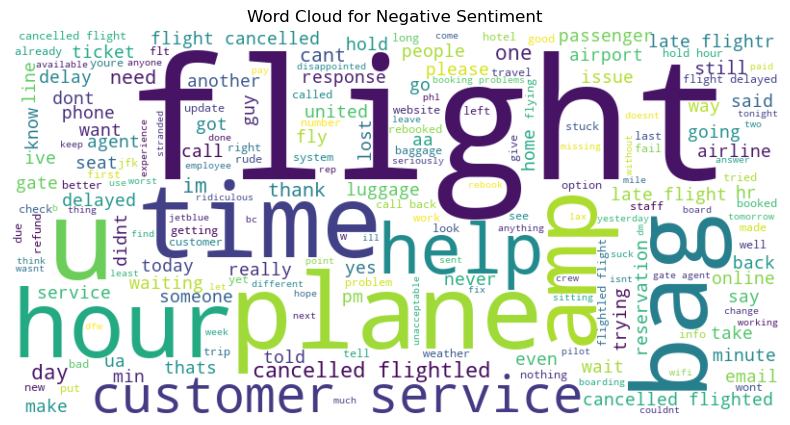

In [10]:
# Generate Word Cloud for each sentiment
for sentiment in data['airline_sentiment'].unique():
    words = ' '.join(data[data['airline_sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.show()

### **Positive Sentiment Word Cloud**
- **Common Words**: "flight," "awesome," "thank," "great," "love," "service."
- **Key Themes**:
  - Customers appreciate good service, flight experiences, and helpful staff.
  - Words like "amazing," "team," "crew," and "help" suggest positive interactions with airline employees.
  - Expressions of gratitude and satisfaction ("thank," "love") dominate.
- **Implication**: Airlines are recognized for excellent service and friendly staff when they perform well.

---

### **Neutral Sentiment Word Cloud**
- **Common Words**: "flight," "help," "need," "please," "check," "time."
- **Key Themes**:
  - Tweets focus on informational or transactional needs, such as flight changes, checking details, or making reservations.
  - Neutral phrases like "please," "help," and "need" indicate non-emotional communication for assistance.
- **Implication**: Neutral tweets generally involve requests for information or support, which don't reflect strong feelings.

---

### **Negative Sentiment Word Cloud**
- **Common Words**: "flight," "hour," "plane," "bag," "customer service," "delayed."
- **Key Themes**:
  - Complaints focus on delays, poor customer service, and lost or mishandled luggage.
  - Words like "hour," "waiting," "cancelled," and "problem" highlight time-related frustrations.
  - Issues with staff ("agent," "customer service") are also prominent.
- **Implication**: Negative tweets frequently address operational issues and unsatisfactory service experiences.

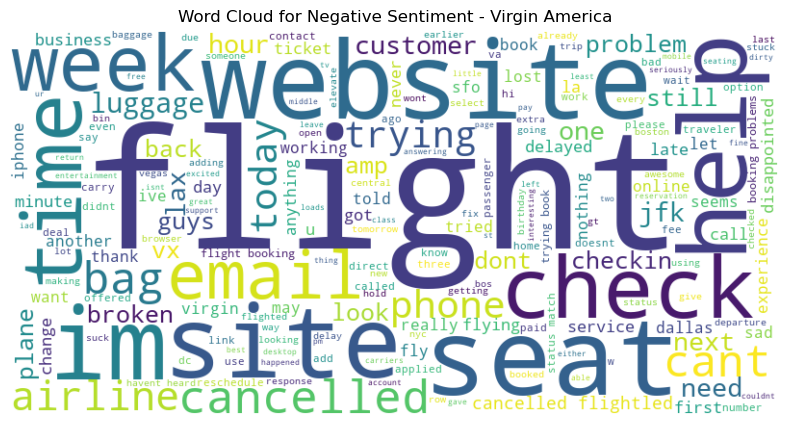

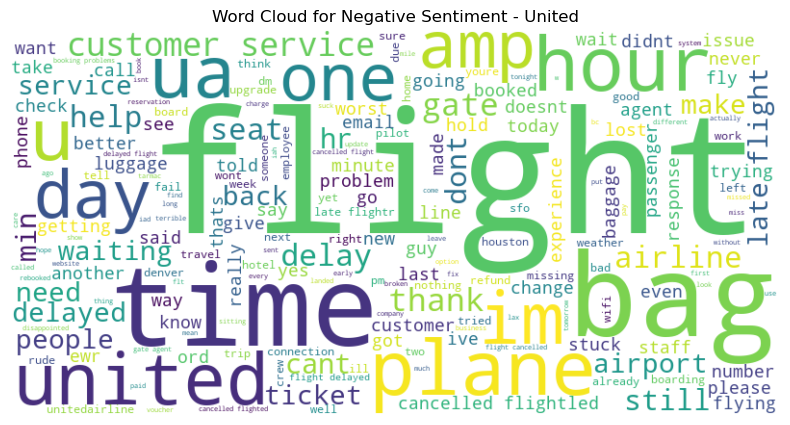

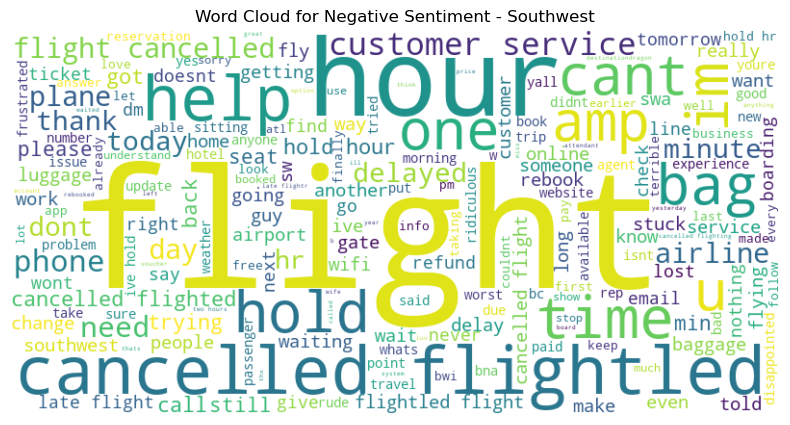

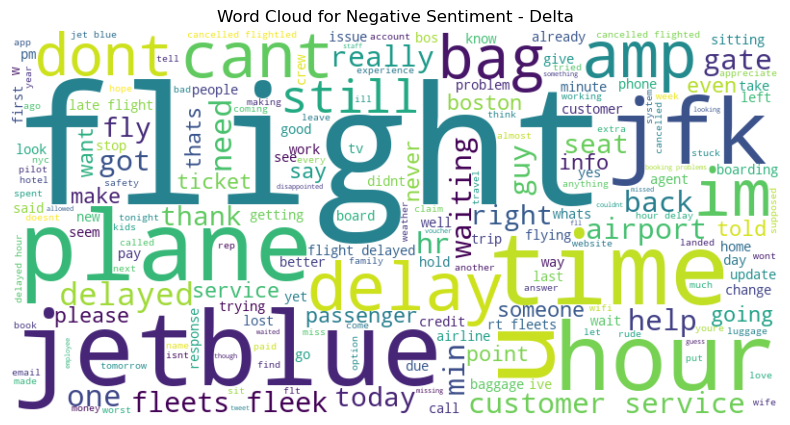

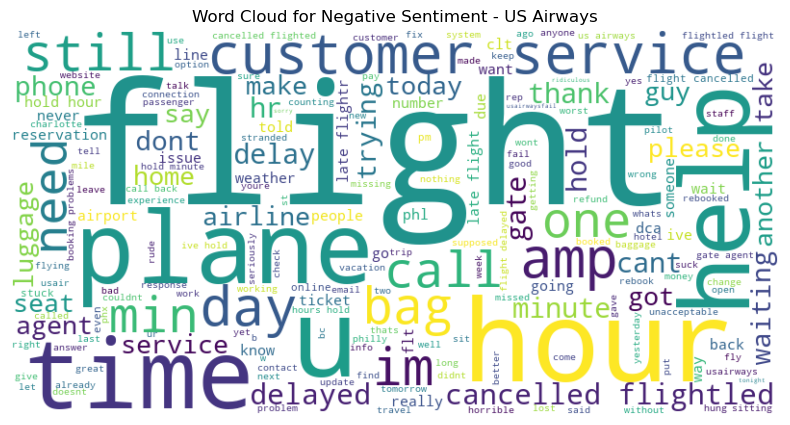

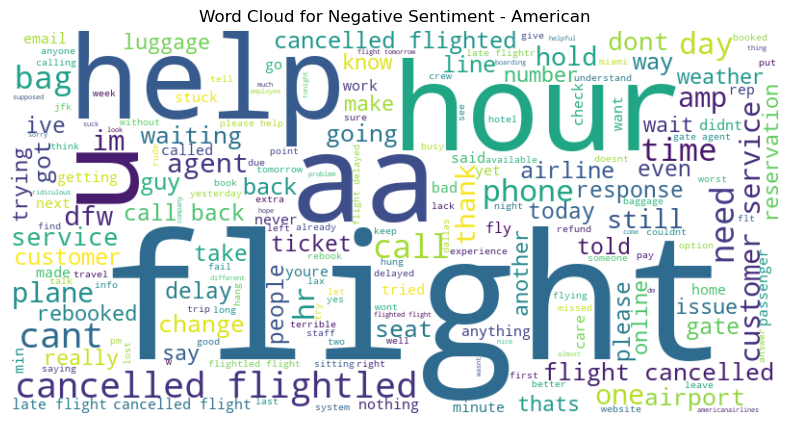

In [11]:
# Generate word clouds for each airline's negative sentiment
for airline in data['airline'].unique():
    negative_tweets = data[(data['airline'] == airline) & (data['airline_sentiment'] == 'negative')]['cleaned_text']
    all_words = ' '.join(negative_tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Negative Sentiment - {airline}')
    plt.show()

### **1. Virgin America**
- **Dominant Words**: "website," "help," "seat," "time," "check," "flight."
- **Key Issues**:
  - Complaints about website functionality, possibly related to booking or checking in.
  - Problems with seat assignments and customer service (e.g., "help").
- **Insights**:
  - Virgin America should focus on improving its online systems and streamlining the check-in process.

---

### **2. United**
- **Dominant Words**: "flight," "plane," "bag," "time," "service," "ua."
- **Key Issues**:
  - Frequent mentions of baggage issues ("bag") and flight delays ("time").
  - Dissatisfaction with customer service.
- **Insights**:
  - United should enhance its baggage handling processes and address delays while improving customer service training.

---

### **3. Southwest**
- **Dominant Words**: "flight," "cancelled," "hour," "service," "customer," "hold."
- **Key Issues**:
  - Numerous cancellations ("cancelled") and long waiting times ("hour").
  - Complaints about poor customer service.
- **Insights**:
  - Southwest needs to focus on reducing cancellations and wait times while enhancing customer support responsiveness.

---

### **4. Delta**
- **Dominant Words**: "flight," "delay," "bag," "hour," "service," "time."
- **Key Issues**:
  - Delays ("delay") and baggage problems ("bag").
  - Mentions of customer service issues and waiting times.
- **Insights**:
  - Delta should prioritize punctuality and improve baggage handling. Proactive communication during delays can also help.

---

### **5. US Airways**
- **Dominant Words**: "flight," "time," "help," "plane," "hour," "customer service."
- **Key Issues**:
  - Complaints about long waiting times ("hour") and delays.
  - Customer service issues are a recurring theme.
- **Insights**:
  - Focus on streamlining operations to minimize delays and invest in better customer service training.

---

### **6. American Airlines**
- **Dominant Words**: "flight," "hour," "help," "aa," "customer service," "bag."
- **Key Issues**:
  - Frequent mentions of delays ("hour"), poor customer service ("help"), and baggage issues.
  - Specific references to the airline ("aa").
- **Insights**:
  - American Airlines should address operational inefficiencies, improve customer service, and focus on resolving baggage-related complaints.

---

### **Comparative Analysis**
1. **Common Themes**:
   - Across all airlines, issues like **delays**, **customer service**, and **baggage handling** dominate negative feedback.
   - Words like "flight," "time," and "service" frequently appear, highlighting shared challenges.

2. **Unique Themes**:
   - **Virgin America**: Website-related complaints are specific to this airline.
   - **United and Delta**: Baggage issues are more pronounced compared to others.
   - **Southwest and US Airways**: Long wait times and cancellations are recurring themes.

## General Classification Model

In [12]:
tfidf = TfidfVectorizer(max_features=2000)

X = tfidf.fit_transform(data['cleaned_text'])
y = data['airline_sentiment']

y = y.map({'positive': 2, 'neutral': 1, 'negative': 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

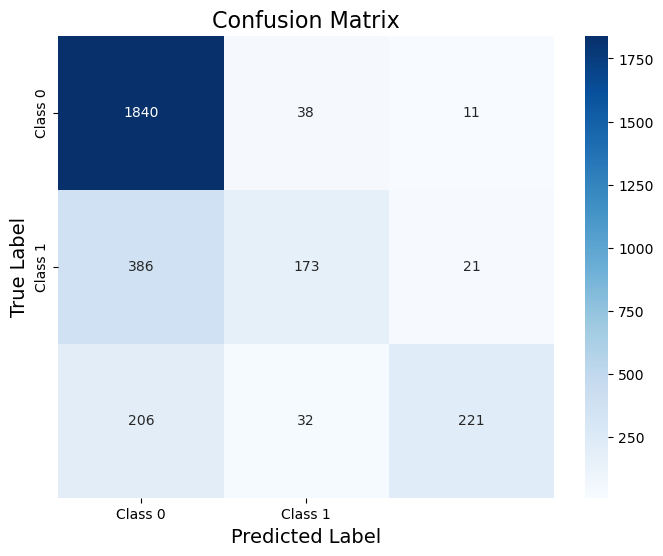


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1889
           1       0.71      0.30      0.42       580
           2       0.87      0.48      0.62       459

    accuracy                           0.76      2928
   macro avg       0.78      0.58      0.63      2928
weighted avg       0.77      0.76      0.73      2928



In [13]:
# Evaluate the model
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

## Classfication Model for Each Airlines

In [14]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=2000)

# Train and evaluate models for each airline
airline_models = {}
for airline in data['airline'].unique():
    airline_data = data[data['airline'] == airline]
    X = tfidf.fit_transform(airline_data['cleaned_text'])
    y = airline_data['airline_sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Naive Bayes classifier
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    airline_models[airline] = {
        "model": model,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }

Use TF-IDF to convert text into numerical features for machine learning:
 - TF-IDF (Term Frequency-Inverse Document Frequency) scores words based on how often they appear in a document relative to the entire dataset.
 - This method highlights important words while down-weighting common ones.
 - Map sentiment labels (positive, neutral, negative) to numerical values for compatibility with machine learning algorithms.

In [15]:
# Display performance for each airline
for airline, metrics in airline_models.items():
    print(f"\nPerformance for {airline}:")
    print("Confusion Matrix:")
    print(metrics["confusion_matrix"])
    print("Classification Report:")
    print(pd.DataFrame(metrics["classification_report"]).transpose())


Performance for Virgin America:
Confusion Matrix:
[[26  6  4]
 [17 13  6]
 [ 5  3 21]]
Classification Report:
              precision    recall  f1-score     support
0              0.541667  0.722222  0.619048   36.000000
1              0.590909  0.361111  0.448276   36.000000
2              0.677419  0.724138  0.700000   29.000000
accuracy       0.594059  0.594059  0.594059    0.594059
macro avg      0.603332  0.602490  0.589108  101.000000
weighted avg   0.598197  0.594059  0.581422  101.000000

Performance for United:
Confusion Matrix:
[[504   1   0]
 [136  12   1]
 [101   2   8]]
Classification Report:
              precision    recall  f1-score     support
0              0.680162  0.998020  0.808989  505.000000
1              0.800000  0.080537  0.146341  149.000000
2              0.888889  0.072072  0.133333  111.000000
accuracy       0.684967  0.684967  0.684967    0.684967
macro avg      0.789684  0.383543  0.362888  765.000000
weighted avg   0.733789  0.684967  0.581888  765.

Use the MultinomialNB model, a simple and efficient algorithm for text classification, especially suitable for datasets with discrete features (like word counts or TF-IDF scores).

Use the confusion matrix and classification report to measure the model’s performance:
 - Precision: Proportion of correct predictions for each class.
 - Recall: Proportion of actual instances correctly predicted.
 - F1-Score: Harmonic mean of precision and recall.

### **1. Virgin America**
- **Performance Overview**:
  - **Accuracy**: 59.4%, indicating moderate performance.
  - **Class 0 (Negative Sentiment)**:
    - High recall (72.2%) but moderate precision (54.2%).
    - The model identifies most negative tweets correctly, but it misclassifies some other tweets as negative.
  - **Class 2 (Positive Sentiment)**:
    - Best performance with both high precision (67.7%) and recall (72.4%).

- **Challenges**:
  - Struggles with Class 1 (Neutral Sentiment), having low recall (36.1%).

- **Insights**:
  - The model is good at distinguishing positive tweets but struggles with neutral ones.

---

### **2. United**
- **Performance Overview**:
  - **Accuracy**: 68.6%.
  - **Class 0 (Negative Sentiment)**:
    - Excellent precision (68.1%) and recall (99.8%).
    - The model identifies nearly all negative tweets correctly.
  - **Class 1 & 2 (Neutral & Positive Sentiment)**:
    - Very poor recall (8.7% for Class 1 and 7.2% for Class 2), indicating the model misses most neutral and positive tweets.

- **Challenges**:
  - Overwhelmingly biased toward Class 0, leading to poor performance on neutral and positive tweets.

- **Insights**:
  - Focus on improving balance between classes, as most positive and neutral tweets are misclassified as negative.

---

### **3. Southwest**
- **Performance Overview**:
  - **Accuracy**: 67.9%.
  - **Class 0 (Negative Sentiment)**:
    - High precision (67.2%) and recall (94.6%), showing the model handles negative sentiment well.
  - **Class 1 (Neutral Sentiment)**:
    - Moderate performance with recall (38.5%) and precision (62.7%).
  - **Class 2 (Positive Sentiment)**:
    - Decent precision (77.5%) but low recall (45.1%).

- **Challenges**:
  - The model struggles with neutral and positive tweets, missing many instances.

- **Insights**:
  - Further tuning is required to handle minority classes (neutral and positive) better.

---

### **4. Delta**
- **Performance Overview**:
  - **Accuracy**: 66.3%.
  - **Class 0 (Negative Sentiment)**:
    - High recall (91.1%) and decent precision (60.8%).
  - **Class 1 (Neutral Sentiment)**:
    - Balanced performance with recall (52%) and precision (71%).
  - **Class 2 (Positive Sentiment)**:
    - Good precision (80.9%) but low recall (46.4%).

- **Challenges**:
  - Similar to Southwest, the model struggles with recall for positive tweets.

- **Insights**:
  - Strong performance on neutral tweets makes Delta's model relatively better balanced.

---

### **5. US Airways**
- **Performance Overview**:
  - **Accuracy**: 77.0%.
  - **Class 0 (Negative Sentiment)**:
    - Excellent recall (100%) and good precision (76.9%).
  - **Class 1 & 2 (Neutral & Positive Sentiment)**:
    - Very poor recall for both classes (0% for Class 1 and 10.9% for Class 2).

- **Challenges**:
  - Heavily biased toward negative tweets, missing most neutral and positive instances.

- **Insights**:
  - US Airways needs better class balancing to recognize positive and neutral tweets.

---

### **6. American Airlines**
- **Performance Overview**:
  - **Accuracy**: 72.6%.
  - **Class 0 (Negative Sentiment)**:
    - Outstanding recall (99.7%) and good precision (72.2%).
  - **Class 1 & 2 (Neutral & Positive Sentiment)**:
    - Very poor recall for neutral (9.8%) and positive (15%) tweets.

- **Challenges**:
  - Similar to United and US Airways, the model overwhelmingly favors Class 0 (negative sentiment).

- **Insights**:
  - Needs improvements for better detection of positive and neutral tweets.

---

### **General Observations Across Airlines**
1. **Strong Performance for Negative Sentiment (Class 0)**:
   - Most airlines show high recall and decent precision for negative tweets, as the dataset is dominated by negative sentiment.

2. **Weak Performance for Neutral and Positive Sentiment (Classes 1 & 2)**:
   - Poor recall for minority classes indicates class imbalance issues, with many tweets misclassified as negative.

3. **Airlines with Balanced Models**:
   - Delta and Southwest demonstrate relatively better balance, as their models perform better on neutral and positive tweets.

In [16]:
# Extract log probabilities for each feature for each class
log_probs = model.feature_log_prob_

# Get the feature names
features = tfidf.get_feature_names_out()

# Select the class (e.g., negative sentiment class 0)
class_index = 0  # Change to 1 for neutral, 2 for positive sentiment
class_index1 = 1
class_index2 = 2

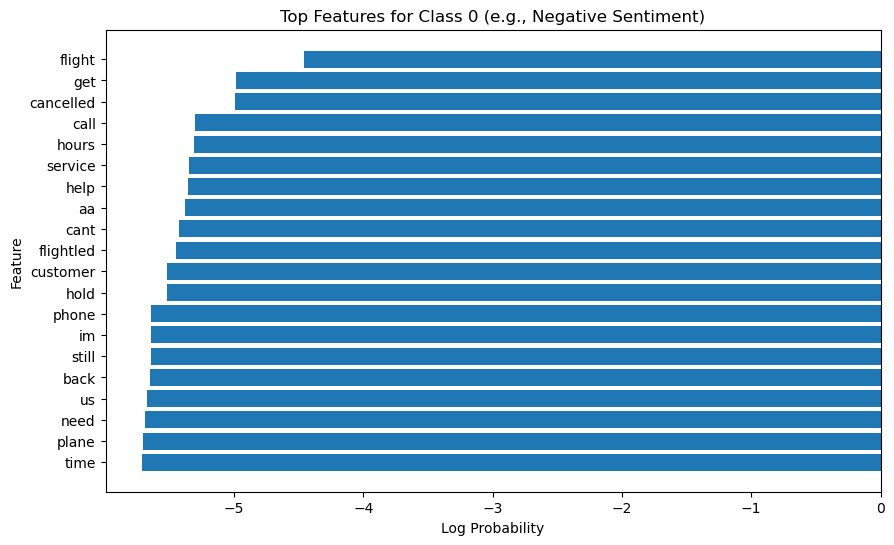

In [17]:
# Combine feature names with their log probabilities
feature_importance = zip(features, log_probs[class_index])

# Sort features by their importance (descending)
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)[:20]

# Split sorted features into words and scores
sorted_words, scores = zip(*sorted_features)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(sorted_words, scores)
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.title(f'Top Features for Class {class_index} (e.g., Negative Sentiment)')
plt.gca().invert_yaxis()
plt.show()

### **Explanation of Key Elements**:
1. **Y-Axis (Features)**: The most influential words for the **negative sentiment class (Class 0)**. These words frequently appear in tweets with negative sentiments and are predictive of this class.
2. **X-Axis (Log Probability)**:
   - Log probabilities measure how strongly a word is associated with the negative sentiment class.
   - A higher absolute value (closer to zero) means the word is more strongly tied to negative sentiment.

---

### **Key Observations**:
- **Most Frequent Words**:
  - **"flight"**: A common word in negative tweets, often referring to delayed or canceled flights.
  - **"cancelled"** and **"hours"**: Highlight operational issues such as flight cancellations and long waiting times.
  - **"service"** and **"customer"**: Reflect dissatisfaction with customer service experiences.
  - **"help" and "call"**: Indicate customers requesting assistance but experiencing inadequate responses.
  - **"time" and "plane"**: Associated with time-related frustrations (e.g., long delays) and issues with airplanes (e.g., technical or boarding problems).
  - **"hold" and "phone"**: Likely refer to customers being placed on hold during calls to customer service.

---

### **Insights from the Features**:
1. **Nature of Negative Sentiment**:
   - Negative tweets typically discuss operational challenges, such as flight delays, cancellations, and long waits.
   - Words like "help" and "call" suggest dissatisfaction with how customer issues are addressed.

2. **Customer Frustration with Service**:
   - Mentions of "service," "hold," and "customer" indicate that poor customer service amplifies negative experiences.

3. **Operational and Communication Failures**:
   - Words like "hours," "cancelled," and "time" suggest that delays and inadequate communication about disruptions are major contributors to negative sentiment.

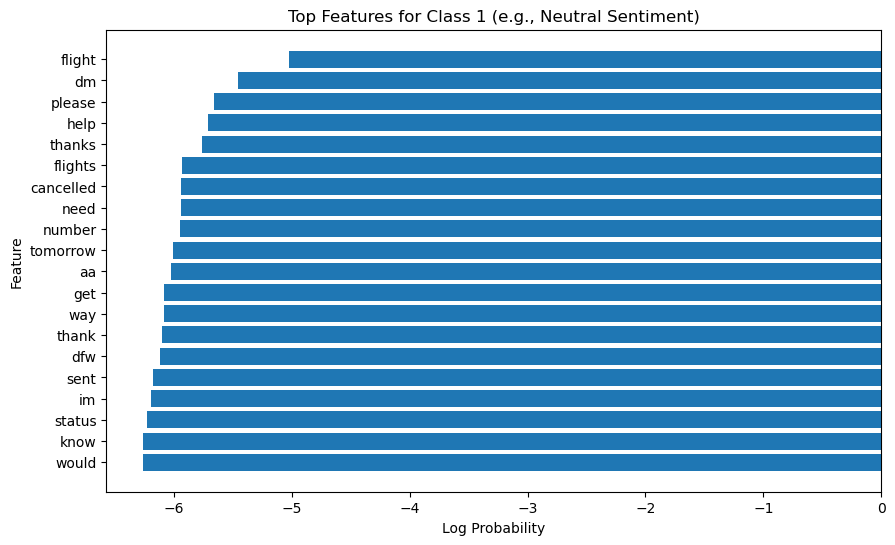

In [18]:
# Combine feature names with their log probabilities
feature_importance = zip(features, log_probs[class_index1])

# Sort features by their importance (descending)
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)[:20]

# Split sorted features into words and scores
sorted_words, scores = zip(*sorted_features)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(sorted_words, scores)
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.title(f'Top Features for Class {class_index1} (e.g., Neutral Sentiment)')
plt.gca().invert_yaxis()
plt.show()

### **Key Observations**:
- **Most Frequent Words**:
  - **"flight"** and **"flights"**: Neutral mentions of flight-related queries or discussions, often used in informational contexts (e.g., flight schedules, delays, or inquiries).
  - **"status"** and **"cancelled"**: Highlight requests for updates or factual mentions of cancellations without expressing strong emotions.
  - **"please"** and **"help"**: Polite words commonly used in customer service interactions, reflecting neutral tones rather than frustration or praise.
  - **"dm"**: Refers to direct messages, likely associated with customer support conversations.
  - **"number"** and **"tomorrow"**: Words tied to specific logistics, such as providing details or making plans for upcoming travel.
  - **"thanks"** and **"thank"**: Neutral expressions of gratitude, often included in formal customer service requests or responses.

---

### **Insights from the Features**:
1. **Nature of Neutral Sentiment**:
   - Neutral tweets are often transactional, discussing logistics, updates, or requests for assistance without a strong positive or negative emotional tone.
   - Words like "dm" and "please" emphasize formal, polite interactions.

2. **Customer Service-Centric**:
   - The frequent appearance of words like "help," "thank," and "dm" suggests that many neutral tweets are directed at resolving issues or seeking information through customer service.

3. **Informational and Polite Tone**:
   - Words like "status," "flights," and "number" are indicative of tweets seeking updates or clarifications, often phrased in a courteous tone.

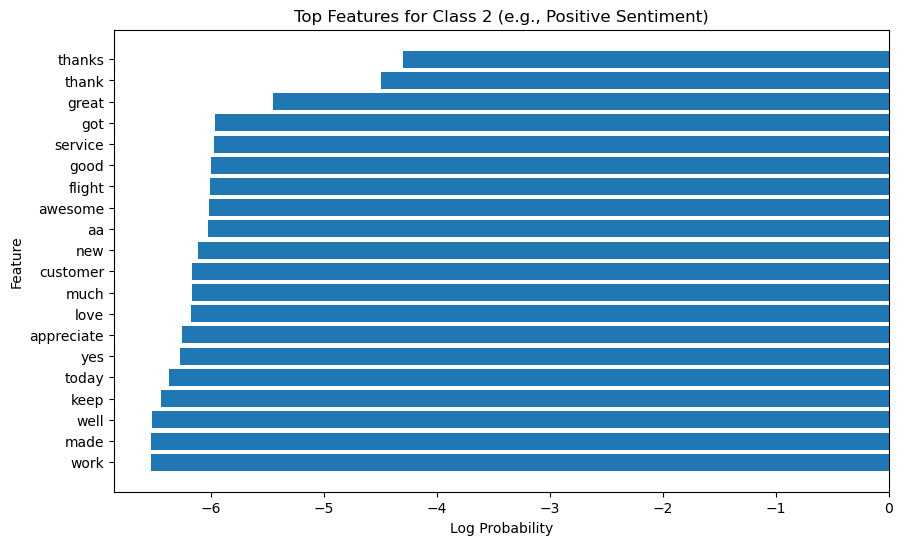

In [19]:
# Combine feature names with their log probabilities
feature_importance = zip(features, log_probs[class_index2])

# Sort features by their importance (descending)
sorted_features = sorted(feature_importance, key=lambda x: x[1], reverse=True)[:20]

# Split sorted features into words and scores
sorted_words, scores = zip(*sorted_features)

# Plot the top features
plt.figure(figsize=(10, 6))
plt.barh(sorted_words, scores)
plt.xlabel('Log Probability')
plt.ylabel('Feature')
plt.title(f'Top Features for Class {class_index2} (e.g., Positive Sentiment)')
plt.gca().invert_yaxis()
plt.show()

### **Key Observations**:
- **Most Frequent Words**:
  - **"thanks"** and **"thank"**: Frequent expressions of gratitude for positive experiences.
  - **"great," "awesome," and "good"**: Words indicating high satisfaction with the service or overall experience.
  - **"customer" and "service"**: Highlight commendation for excellent customer service.
  - **"crew" and "work"**: Refer to positive recognition of the airline crew and their efforts.
  - **"love" and "appreciate"**: Strongly positive emotional expressions that show genuine customer delight.
  - **"flight," "new," and "today"**: Neutral terms included in positive contexts, often used to describe enjoyable travel experiences.

---

### **Insights from the Features**:
1. **Nature of Positive Sentiment**:
   - Positive tweets frequently focus on gratitude, satisfaction, and praise for the service or staff.
   - Words like "great," "awesome," and "love" emphasize the emotional tone in positive feedback.

2. **Customer Service Recognition**:
   - The inclusion of words like "customer," "service," and "crew" suggests that exceptional staff behavior is a common driver of positive sentiment.

3. **Operational Excellence**:
   - Mentions of "flight" and "today" in positive contexts indicate appreciation for timely and smooth travel experiences.

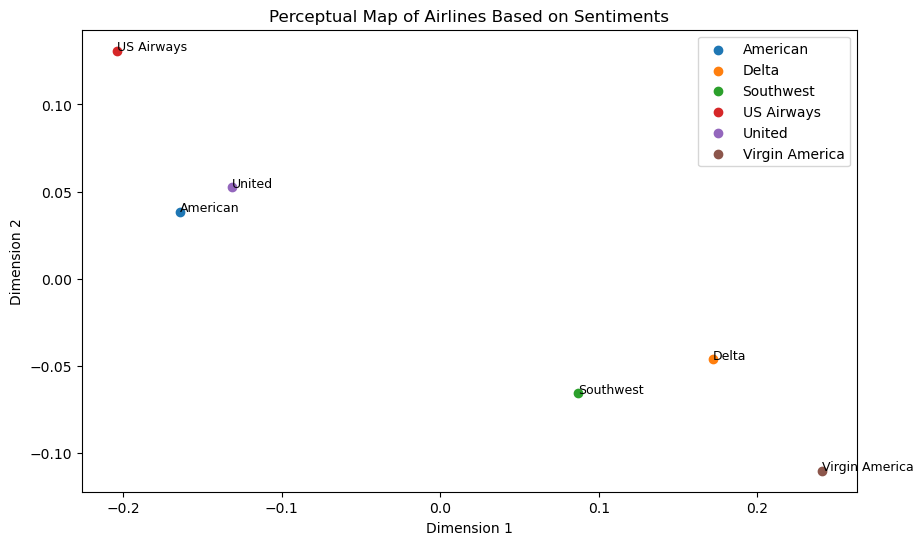

In [20]:
# Generate perceptual map for airlines
mds = MDS(n_components=2, random_state=42)
mds_result = mds.fit_transform(airline_sentiment_percentages.fillna(0))

# Visualize the perceptual map
plt.figure(figsize=(10, 6))
for i, airline in enumerate(airline_sentiment_percentages.index):
    plt.scatter(mds_result[i, 0], mds_result[i, 1], label=airline)
    plt.text(mds_result[i, 0], mds_result[i, 1], airline, fontsize=9)

plt.title('Perceptual Map of Airlines Based on Sentiments')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

### **Explanation of the Perceptual Map**
This perceptual map visually represents the **sentiment profiles of airlines** based on their positions in a two-dimensional space. The axes (Dimension 1 and Dimension 2) are derived from sentiment data using **Multidimensional Scaling (MDS)**. Here's the breakdown:

---

### **Key Elements of the Map**:
1. **X-Axis (Dimension 1)** and **Y-Axis (Dimension 2)**:
   - These dimensions represent abstract features of sentiment similarity and dissimilarity among the airlines.
   - Airlines positioned closer to each other exhibit similar sentiment distributions, while those farther apart have distinct sentiment profiles.

2. **Position of Airlines**:
   - Each airline is plotted as a point, with its label and color corresponding to the legend.

---

### **Observations**:
1. **Virgin America**:
   - Positioned far to the right and below other airlines.
   - Indicates a distinct sentiment profile with a higher proportion of **positive feedback** compared to others.
   - Strength in operational reliability and customer satisfaction may contribute to this unique position.

2. **Delta and Southwest**:
   - Positioned in the bottom-right quadrant and close to each other.
   - Suggests these airlines share similar sentiment distributions, likely with a mix of **neutral and positive sentiments**.

3. **US Airways**:
   - Positioned far to the top-left, separated from other airlines.
   - This distance indicates a sentiment profile dominated by **negative feedback**, possibly due to recurring operational or customer service issues.

4. **United and American**:
   - Located near the center-left and close to each other.
   - Their positioning suggests sentiment profiles leaning more toward **negative sentiments**, but not as extreme as US Airways.

---

### **Insights**:
1. **Distinct Positive Performer**:
   - Virgin America stands out as the airline with the most favorable sentiment, making it a benchmark for customer satisfaction.

2. **Opportunities for Improvement**:
   - US Airways, United, and American need significant focus on reducing negative sentiment. Efforts should target operational reliability, customer service, and timely communication.

3. **Competitive Similarity**:
   - Delta and Southwest have overlapping sentiment profiles, indicating similar strengths and challenges. They should focus on leveraging neutral interactions to convert them into positive experiences.

4. **Positioning Strategy**:
   - Airlines in the center (United and American) might aim to differentiate themselves from each other by addressing specific issues contributing to their negative sentiment.